<a href="https://colab.research.google.com/github/emzad05/SJSU_Masters_Final_Project_EmmanuelN/blob/Code-Development/RE_on_Biomedical_texts_using_ML_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Relation Extraction in Biomedical Literature using Machine Learning Methods

### Emmanuel Nyangweso

##### 04/2022

### Abstract:

Medical decisions concerning patient healthcare heavily rely on evidence-based medicine
from patient histories, clinical repositories, medical journals and medical databases.
Automated Information Extraction (IE) of disease-treatment relations and their classification
can significantly improve efficiency in medical decision support. Using the Machine Learning
(ML) task of Natural Language Processing (NLP), Relation Extraction (RE) from natural
language biomedical texts is performed in order to identify semantic relations between
diseases and treatments. Deep learning (DL) models are built and evaluated on classification
accuracy and F1-scores, finding that fine-tuned pretrained models perform best on classifying
the semantic relations between diseases and treatment entities.


## Notebook Setup

In [ ]:
# Mounting Drive: 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 212 kB 54.5 MB/s 
     |████████████████████████████████| 136 kB 52.5 MB/s 
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 53.5 MB/s 
     |████████████████████████████████| 127 kB 50.0 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 72.5 MB/s 
     |████████████████████████████████| 271 kB 66.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

import pandas as pd 
import numpy as np
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import tensorflow as tf
from tensorflow import keras

print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

Tensorflow Version: 2.8.0
Keras Version: 2.8.0


In [ ]:
# Verifying GPU present:

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
RANDOM_SEED = 456
np.random.seed(RANDOM_SEED)

## Data Exploration

Full dataset exploration, prior to subsampling

In [ ]:
# Reading in dataset and converting into a pandas dataframe 

# Code references: https://github.com/emanuel-metzenthin/snorkel-biomedical-information-extraction/blob/master/SNORKEL-Biomedical-Information-Extraction.ipynb

f = open('/content/drive/MyDrive/Colab Notebooks/Final Project Work/Datasets/BioText/sentences_with_roles_and_relations.txt', encoding = "ISO-8859-1")
f_data = []
for line in f.readlines():
    line = line[:-1] # Remove linebreak
    f_data.append(line.split('||'))
f.close()


In [ ]:
BioText_full_df = pd.DataFrame(f_data, columns = ['Sentence', 'Relationship'])

In [ ]:
BioText_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655 entries, 0 to 3654
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sentence      3655 non-null   object
 1   Relationship  3655 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [ ]:
BioText_full_df.describe()

,Sentence,Relationship
count,3655,3655
unique,3569,9
top,Online .,NONE
freq,17,1818


In [ ]:
BioText_full_df['Relationship'].value_counts()

NONE                1818
TREAT_FOR_DIS        830
DISONLY              629
TREATONLY            169
TO_SEE                75
PREVENT               63
VAGUE                 37
SIDE_EFF              30
TREAT_NO_FOR_DIS       4
Name: Relationship, dtype: int64

In [ ]:
BioText_full_df.tail()

,Sentence,Relationship
3650,Special report : <TREAT> pressure-reducing su...,TREAT_FOR_DIS
3651,<TREAT> Intravenous immune globulin </TREAT> ...,TREAT_FOR_DIS
3652,<TREAT> External counterpulsation </TREAT> fo...,TREAT_FOR_DIS
3653,<TREAT> Intra-articular hyaluronan injections...,TREAT_FOR_DIS
3654,<DIS_PREV> Pneumococcal </DIS_PREV> <TREAT_PR...,PREVENT


In [ ]:
sample_loc = 3651
sample_sentence = BioText_full_df['Sentence'].iloc[sample_loc]
sample_relation = BioText_full_df['Relationship'].iloc[sample_loc]
print(sample_sentence)
print(sample_relation)

 <TREAT> Intravenous immune globulin </TREAT> for <DIS> recurrent spontaneous abortion </DIS> .
TREAT_FOR_DIS


## Dataset preprocessing

In [ ]:
f = open('/content/drive/MyDrive/Colab Notebooks/Final Project Work/Datasets/BioText/sentences_with_roles_and_relations.txt', encoding = "ISO-8859-1")
f_data = []
for line in f.readlines():
    line = line[:-1] # Remove linebreak
    f_data.append(line.split('||'))
f.close()

rows = []
for l in f_data:
    if l[1] not in ['NONE', 'TREATONLY', 'DISONLY', 'TO_SEE']:
        dis_re = re.compile('<DIS.*>(.*)</DIS.*>')
        disease = dis_re.search(l[0]).group(1)
        treat_re = re.compile('<TREAT.*>(.*)</TREAT.*>')
        treat = treat_re.search(l[0]).group(1)
        
        sent = re.sub(r'<.*?>', '', l[0])
        
        rows.append([sent, l[1], treat.upper(), disease.upper()])

BioText = pd.DataFrame(data=rows, columns=['Sentence', 'Type', 'Treatment', 'Disease'])


In [ ]:
# Dataframe contains sentences with disease-treatment relations
print('Shape of BioText data: {}'.format(BioText.shape))
BioText.head()

Shape of BioText data: (964, 4)


,Sentence,Type,Treatment,Disease
0,We conclude that to reduce the rate of macros...,PREVENT,GOOD GLYCEMIC CONTROL,MACROSOMIC INFANTS IN GESTATIONAL DIABETES CA...
1,Although long-term survival can be achieved by...,VAGUE,CORRECTIVE SURGERY,HYPOPLASIA
2,OBJECTIVE : To study the safety and efficacy ...,TREAT_FOR_DIS,METHYLPHENIDATE,ATTENTION DEFICIT HYPERACTIVITY DISORDER ( AD...
3,CONCLUSION : Methylphenidate is effective in...,TREAT_FOR_DIS,METHYLPHENIDATE,ADHD
4,BACKGROUND : Antiplatelet therapy with aspir...,TREAT_FOR_DIS,ANTIPLATELET THERAPY WITH ASPIRIN AND SYSTEMA...,CARDIOVASCULAR MORBIDITY AND MORTALITY AFTER ...


In [ ]:
BioText['Type'].value_counts()

TREAT_FOR_DIS       830
PREVENT              63
VAGUE                37
SIDE_EFF             30
TREAT_NO_FOR_DIS      4
Name: Type, dtype: int64

### Categorical Encoding of Relation (Type)

In [ ]:
from sklearn import preprocessing

labels = BioText['Type']
labels_arr = np.array(labels)

label_encoder = preprocessing.LabelEncoder()
labels_vec = label_encoder.fit_transform(labels_arr)
BioText['Type_ENC'] = labels_vec

In [ ]:
# Dataframe contains sentences with disease-treatment relations, categorized
print('Shape of categorized BioText data: {}'.format(BioText.shape))
BioText.head()

Shape of categorized BioText data: (964, 5)


,Sentence,Type,Treatment,Disease,Type_ENC
0,We conclude that to reduce the rate of macros...,PREVENT,GOOD GLYCEMIC CONTROL,MACROSOMIC INFANTS IN GESTATIONAL DIABETES CA...,0
1,Although long-term survival can be achieved by...,VAGUE,CORRECTIVE SURGERY,HYPOPLASIA,4
2,OBJECTIVE : To study the safety and efficacy ...,TREAT_FOR_DIS,METHYLPHENIDATE,ATTENTION DEFICIT HYPERACTIVITY DISORDER ( AD...,2
3,CONCLUSION : Methylphenidate is effective in...,TREAT_FOR_DIS,METHYLPHENIDATE,ADHD,2
4,BACKGROUND : Antiplatelet therapy with aspir...,TREAT_FOR_DIS,ANTIPLATELET THERAPY WITH ASPIRIN AND SYSTEMA...,CARDIOVASCULAR MORBIDITY AND MORTALITY AFTER ...,2


In [ ]:
num_relations=len(BioText.Type_ENC.unique())
print(num_relations)

5


In [ ]:
integer_mapping = {l: i for i, l in enumerate(label_encoder.classes_)}
print(integer_mapping)

{'PREVENT': 0, 'SIDE_EFF': 1, 'TREAT_FOR_DIS': 2, 'TREAT_NO_FOR_DIS': 3, 'VAGUE': 4}


### Train, test split

In [ ]:
BioTrain, BioTest = train_test_split(BioText, test_size = .20, random_state= 45) 
# BioTrain, BioVal = train_test_split(BioTrain, test_size = .20, random_state= 45)

In [ ]:
print('Shape of BioTrain data: {}'.format(BioTrain.shape))
# print('Shape of BioVal data: {}'.format(BioVal.shape))
print('Shape of BioTest data: {}'.format(BioTest.shape))

Shape of BioTrain data: (771, 5)
Shape of BioTest data: (193, 5)


In [ ]:
BioTrain['Type'].value_counts()

TREAT_FOR_DIS       665
PREVENT              50
VAGUE                30
SIDE_EFF             23
TREAT_NO_FOR_DIS      3
Name: Type, dtype: int64

Text(0, 0.5, 'Samples')

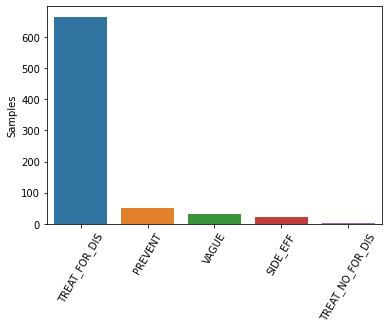

In [ ]:
x=BioTrain['Type'].value_counts()
sns.barplot(x.index,x)
plt.xticks(rotation=60)
plt.gca().set_ylabel('Samples')

In [ ]:
# BioVal['Type'].value_counts()

In [ ]:
BioTest.reset_index(drop=True, inplace=True)
BioTest['Type'].value_counts()

TREAT_FOR_DIS       165
PREVENT              13
VAGUE                 7
SIDE_EFF              7
TREAT_NO_FOR_DIS      1
Name: Type, dtype: int64

In [ ]:
BioTrain.reset_index(drop=True, inplace=True)

print('Shape of combined original Biotrain: {}'.format(BioTrain.shape))
BioTrain.head()


Shape of combined original Biotrain: (771, 5)


,Sentence,Type,Treatment,Disease,Type_ENC
0,New therapies for severe meningococcal dis...,TREAT_FOR_DIS,NEW THERAPIES,SEVERE MENINGOCOCCAL DISEASE,2
1,Pharmacological management of acute myocar...,TREAT_FOR_DIS,PHARMACOLOGICAL MANAGEMENT,ACUTE MYOCARDIAL INFARCTION,2
2,Aspirin therapy for cardiovascular disease .,TREAT_FOR_DIS,ASPIRIN THERAPY,CARDIOVASCULAR DISEASE,2
3,A 66-year-old male engineer diagnosed with m...,TREAT_FOR_DIS,"THORACOTOMY , RADIOTHERAPY , AND CHEMOTHERAPY",MALIGNANT PLEURAL MESOTHELIOMA,2
4,amifostine ( wr-2721 ) is a cytoprotective ...,PREVENT,AMIFOSTINE ( WR-2721 ),TOXIC EFFECTS OF CHEMOTHERAPY AND RADIOTHERAPY,0


## Data Augmentation

In [ ]:
from tqdm import tqdm

In [ ]:
!pip install numpy requests nlpaug

     |████████████████████████████████| 410 kB 5.2 MB/s 


In [ ]:
!pip install torch>=1.6.0 transformers>=3.4.0 sentencepiece

In [ ]:
# sampleText = BioTrain.iloc[3]['Sentence']
# print(sampleText)

sampleTexts = BioTrain.iloc[3]['Sentence']
print(sampleTexts)

 A 66-year-old male engineer diagnosed with  malignant pleural mesothelioma  4 years previously had  thoracotomy , radiotherapy , and chemotherapy  .


In [ ]:

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [ ]:

aug_bert_model = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")

print("Original:")
print(sampleTexts)

print("Augmented Texts:")
for ii in range(5):
  augmented_text = aug_bert_model.augment(sampleTexts)
  print(augmented_text)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Original:
 A 66-year-old male engineer diagnosed with  malignant pleural mesothelioma  4 years previously had  thoracotomy , radiotherapy , and chemotherapy  .
Augmented Texts:
when a healthy 66 - year - old gay male aerospace engineer diagnosed young with the malignant bilateral pleural bypass mesothelioma 4 years previously and had thoracotomy, radiotherapy, and cancer chemotherapy.
a then 66 - five year - though old male engineer who diagnosed with persistent malignant and pleural invasive mesothelioma over 4 years previously had undergone thoracotomy, iv radiotherapy, and chemotherapy.
even a 66 - five year - old trans male electronics engineer man diagnosed later with malignant pleural mesothelioma 4 metric years previously had thoracotomy, periodic radiotherapy, medications and even chemotherapy.
a 66 - 10 year - pin old young male consultant engineer diagnosed wilson with a malignant pleural duct mesothelioma identified 4 years previously was had thoracotomy, emergency radiother

In [ ]:
def augment_text(to_aug_df,num_aug_samples=20,augpercent=0.2, type_categ=1):
    aug_bert_model.aug_p=augpercent
    new_aug_list=[]
    
    ##dropping rest of other category samples from augmentatation
    df_categ=to_aug_df[to_aug_df.Type_ENC==type_categ].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_categ),num_aug_samples)):
        
            orig_Sentence = df_categ.iloc[i]['Sentence']
            orig_Type = df_categ.iloc[i]['Type']
            orig_Treatment = df_categ.iloc[i]['Treatment']
            orig_Disease = df_categ.iloc[i]['Disease']
            orig_Type_ENC = df_categ.iloc[i]['Type_ENC']

            augmented_Sentence = aug_bert_model.augment(orig_Sentence)
            new_aug_list.append([augmented_Sentence, orig_Type, orig_Treatment, orig_Disease,orig_Type_ENC])

                    
    ## dataframe of category specific augmented text
    to_aug_df=pd.DataFrame(new_aug_list, columns=['Sentence','Type','Treatment','Disease','Type_ENC'])

    return to_aug_df

### Calling the Augment function

In [ ]:
aug_train_Treat_no_for_dis = augment_text(BioTrain,num_aug_samples=40,type_categ=3)   ## change samples to 0 for no augmentation

100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


In [ ]:
orig_sentences = BioTrain[BioTrain.Type_ENC==3]

with pd.option_context('display.max_colwidth', None):
  display(orig_sentences.Sentence.head())

176                                                                                                                 Evidence for double resistance to  permethrin and malathion  in  head lice  .
489                                       To avoid medicalising a self limiting illness doctors should avoid  antibiotics  or offer a delayed prescription for most patients with  sore throat  .
611      Subcutaneous injection of irradiated LLC-IL2  did not affect the growth of preexisting  s.c. tumors  and also did not improve survival of mice bearing the  lung or peritoneal tumors  .
Name: Sentence, dtype: object

In [ ]:
sample_aug_sent = aug_train_Treat_no_for_dis.iloc[0]['Sentence']
print(sample_aug_sent)

to effectively avoid unnecessary medicalising for a self limiting illness doctors should avoid antibiotics or offer out a delayed prescription replacement for most patients with sore throat.


In [ ]:
print('Shape of augmented train_Treat_no_for_dis subset: {}'.format(aug_train_Treat_no_for_dis.shape))
aug_train_Treat_no_for_dis.head()

Shape of augmented train_Treat_no_for_dis subset: (40, 5)


,Sentence,Type,Treatment,Disease,Type_ENC
0,to effectively avoid unnecessary medicalising ...,TREAT_NO_FOR_DIS,ANTIBIOTICS,SORE THROAT,3
1,to avoid further medicalising a self limiting ...,TREAT_NO_FOR_DIS,ANTIBIOTICS,SORE THROAT,3
2,the subcutaneous fluid injection of irradiated...,TREAT_NO_FOR_DIS,SUBCUTANEOUS INJECTION OF IRRADIATED LLC-IL2,LUNG OR PERITONEAL TUMORS,3
3,broad evidence stands for double resistance to...,TREAT_NO_FOR_DIS,PERMETHRIN AND MALATHION,HEAD LICE,3
4,subcutaneous injection initiation of irradiate...,TREAT_NO_FOR_DIS,SUBCUTANEOUS INJECTION OF IRRADIATED LLC-IL2,LUNG OR PERITONEAL TUMORS,3


In [ ]:
aug_train_Side_EFF = augment_text(BioTrain,num_aug_samples=20,type_categ=1)   ## change samples to 0 for no augmentation

100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


In [ ]:
aug_train_Vague = augment_text(BioTrain,num_aug_samples=20,type_categ=4)   ## change samples to 0 for no augmentation

100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


In [ ]:
aug_train_Prevent = augment_text(BioTrain,num_aug_samples=20,type_categ=0)   ## change samples to 0 for no augmentation

100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


In [ ]:
from sklearn.utils import shuffle


In [ ]:
aug_train_samples=shuffle(pd.concat([aug_train_Treat_no_for_dis,
                                     aug_train_Side_EFF,
                                     aug_train_Vague,
                                     aug_train_Prevent]), random_state = 43).reset_index(drop=True)                                                        
                                                    

In [ ]:
print('Shape of concatenated aug_train_samples: {}'.format(aug_train_samples.shape))
aug_train_samples.head()

Shape of concatenated aug_train_samples: (100, 5)


,Sentence,Type,Treatment,Disease,Type_ENC
0,double subcutaneous knockout injection of irra...,TREAT_NO_FOR_DIS,SUBCUTANEOUS INJECTION OF IRRADIATED LLC-IL2,LUNG OR PERITONEAL TUMORS,3
1,the subcutaneous fluid injection of irradiated...,TREAT_NO_FOR_DIS,SUBCUTANEOUS INJECTION OF IRRADIATED LLC-IL2,LUNG OR PERITONEAL TUMORS,3
2,to help avoid easily medicalising a self limit...,TREAT_NO_FOR_DIS,ANTIBIOTICS,SORE THROAT,3
3,evidence for possible double resistance to the...,TREAT_NO_FOR_DIS,PERMETHRIN AND MALATHION,HEAD LICE,3
4,"initially, all eyes tested that had acquired o...",SIDE_EFF,VITRECTOMY,OPACIFICATION,1


In [ ]:
aug_BioTrain=shuffle(pd.concat([aug_train_samples,
                                         BioTrain]), random_state = 43).reset_index(drop=True) 

In [ ]:
print('Shape of combined augmented and original Biotrain: {}'.format(aug_BioTrain.shape))
aug_BioTrain.head()

Shape of combined augmented and original Biotrain: (871, 5)


,Sentence,Type,Treatment,Disease,Type_ENC
0,A comparison of noninvasive positive-pressur...,TREAT_FOR_DIS,CONVENTIONAL MECHANICAL VENTILATION,ACUTE RESPIRATORY FAILURE,2
1,Acute effect of lorazepam on respiratory mu...,VAGUE,LORAZEPAM,CHRONIC OBSTRUCTIVE PULMONARY DISEASE,4
2,The rationale of extended resection for co...,TREAT_FOR_DIS,EXTENDED RESECTION,COMPLICATED CANCER OF THE LARGE BOWEL,2
3,"Oral contraceptives , thrombosis , and cy...",VAGUE,ORAL CONTRACEPTIVES,THROMBOSIS,4
4,to avoid future medicalising from a self limit...,TREAT_NO_FOR_DIS,ANTIBIOTICS,SORE THROAT,3


### New Train data value counts

In [ ]:
aug_BioTrain['Type'].value_counts()

TREAT_FOR_DIS       665
PREVENT              70
VAGUE                50
TREAT_NO_FOR_DIS     43
SIDE_EFF             43
Name: Type, dtype: int64

Text(0, 0.5, 'Samples')

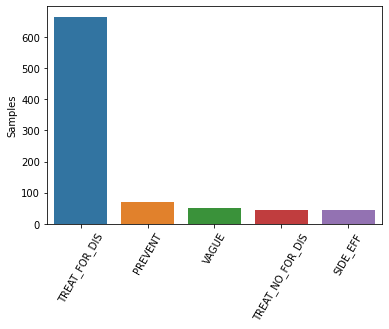

In [ ]:
x=aug_BioTrain['Type'].value_counts()
sns.barplot(x.index,x)
plt.xticks(rotation=60)
plt.gca().set_ylabel('Samples')

## Model Development and Testing

### LSTM Models

#### Standard setup

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical # don't think i use this.
# from tensorflow.keras.utils import np_utils

In [ ]:
from keras.models import Model
from keras.layers import Bidirectional, LSTM, Activation, Dense, Dropout, Input, Embedding

In [ ]:

n_most_common_words = 20000 # vocabulary size
max_len = 100

# Initialization
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)

# Fit 
tokenizer.fit_on_texts(aug_BioTrain['Sentence'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

# Transformation
x_train_sequences = tokenizer.texts_to_sequences(aug_BioTrain['Sentence'].values)
x_test_sequences = tokenizer.texts_to_sequences(BioTest['Sentence'].values)


# Padding
X_train = sequence.pad_sequences(x_train_sequences, maxlen=max_len)
X_test = sequence.pad_sequences(x_test_sequences, maxlen=max_len)

Found 3618 unique tokens.


In [ ]:
y_train = to_categorical(aug_BioTrain['Type_ENC'] , num_classes=num_relations) # from keras.utils.np_utils
# y_val = to_categorical(BioVal['Type_ENC'] , num_classes=num_relations)
y_test = to_categorical(BioTest['Type_ENC'] , num_classes=num_relations)

In [ ]:
rounded_y_test=np.argmax(y_test, axis=1)
np.unique(rounded_y_test)

array([0, 1, 2, 3, 4])

#### 1 layer LSTM

##### Model setup

In [ ]:

embedding_size = 300
model_lstm_1 = keras.models.Sequential()
model_lstm_1.add(Embedding(n_most_common_words, embedding_size, input_length=X_train.shape[1]))
model_lstm_1.add(LSTM(128))
model_lstm_1.add(Dense(y_train.shape[1], activation='softmax'))
model_lstm_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          6000000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 6,220,293
Trainable params: 6,220,293
Non-trainable params: 0
_________________________________________________________________
None


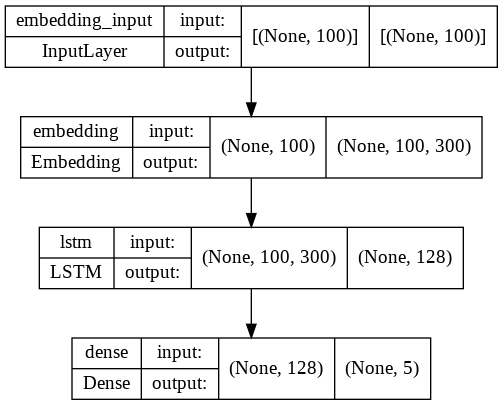

In [ ]:
keras.utils.plot_model(model_lstm_1, to_file="my_ref3_model.png", show_shapes=True)

##### Training and validation loss and accuracy

In [ ]:
history = model_lstm_1.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test,y_test))

Epoch 1/20
7/7 [==============================] - 7s 106ms/step - loss: 1.4199 - accuracy: 0.6751 - val_loss: 0.6798 - val_accuracy: 0.8549
Epoch 2/20
7/7 [==============================] - 0s 24ms/step - loss: 0.8788 - accuracy: 0.7635 - val_loss: 0.6342 - val_accuracy: 0.8549
Epoch 3/20
7/7 [==============================] - 0s 24ms/step - loss: 0.7670 - accuracy: 0.7635 - val_loss: 0.6086 - val_accuracy: 0.8549
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6475 - accuracy: 0.7784 - val_loss: 0.5758 - val_accuracy: 0.8549
Epoch 5/20
7/7 [==============================] - 0s 20ms/step - loss: 0.4984 - accuracy: 0.8703 - val_loss: 0.5671 - val_accuracy: 0.8549
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 0.3744 - accuracy: 0.9104 - val_loss: 0.5181 - val_accuracy: 0.8497
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 0.2845 - accuracy: 0.9380 - val_loss: 0.6307 - val_accuracy: 0.8446
Epoch 8/20
7/7 [==========

In [ ]:
val_loss, val_acc = model_lstm_1.evaluate(X_test, y_test)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

7/7 [==============================] - 0s 17ms/step - loss: 0.9073 - accuracy: 0.8446
Validation Loss: 0.9073234796524048
Validation Accuracy: 0.8445596098899841


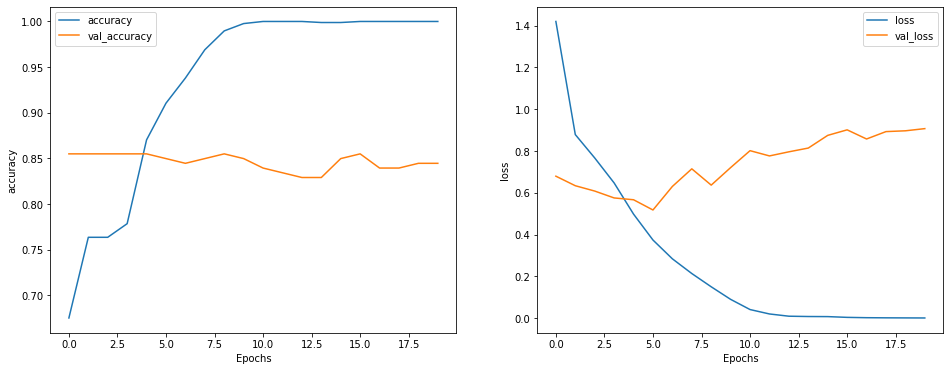

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
print(model_lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          6000000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 6,220,293
Trainable params: 6,220,293
Non-trainable params: 0
_________________________________________________________________
None


##### Confusion matrix and classification report

In [ ]:
print("Categorical Mapping: ", integer_mapping)

Categorical Mapping:  {'PREVENT': 0, 'SIDE_EFF': 1, 'TREAT_FOR_DIS': 2, 'TREAT_NO_FOR_DIS': 3, 'VAGUE': 4}


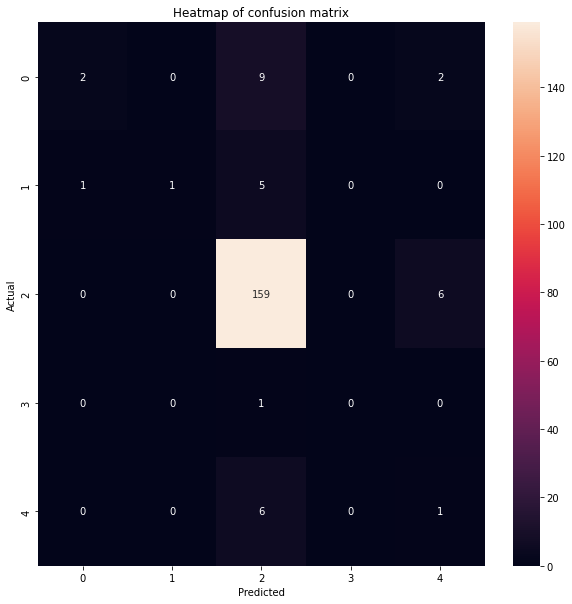

In [ ]:

prediction_probas = model_lstm_1.predict(X_test) 
predictions = np.argmax(prediction_probas, axis=1)

conf_matrix = confusion_matrix(rounded_y_test, predictions)

fig, ax = plt.subplots(figsize =(10,10))

sns.heatmap(conf_matrix, annot=True, fmt="d");

plt.title('Heatmap of confusion matrix') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 

plt.show()

In [ ]:
print(classification_report(rounded_y_test, predictions, digits=3, zero_division=0)) #Delete zero_division param to see warnings

              precision    recall  f1-score   support

           0      0.667     0.154     0.250        13
           1      1.000     0.143     0.250         7
           2      0.883     0.964     0.922       165
           3      0.000     0.000     0.000         1
           4      0.111     0.143     0.125         7

    accuracy                          0.845       193
   macro avg      0.532     0.281     0.309       193
weighted avg      0.840     0.845     0.818       193



##### Saving model

In [ ]:
# !mkdir -p lstm_1_saved_model    #/content/lstm_1_saved_model
# model_lstm_1.save('/content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_1_saved_model/lstm_1_model')

# # /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_1saved_model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_1_saved_model/lstm_1_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_1_saved_model/lstm_1_model/assets


#### 2 layer LSTM

##### Model setup

In [ ]:

embedding_size = 300
model_lstm_2 = keras.models.Sequential()
model_lstm_2.add(Embedding(n_most_common_words, embedding_size, input_length=X_train.shape[1]))
model_lstm_2.add(LSTM(128,return_sequences=True))
model_lstm_2.add(LSTM(128))
model_lstm_2.add(Dense(y_train.shape[1], activation='softmax'))
model_lstm_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_lstm_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          219648    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 6,351,877
Trainable params: 6,351,877
Non-trainable params: 0
_________________________________________________________________
None


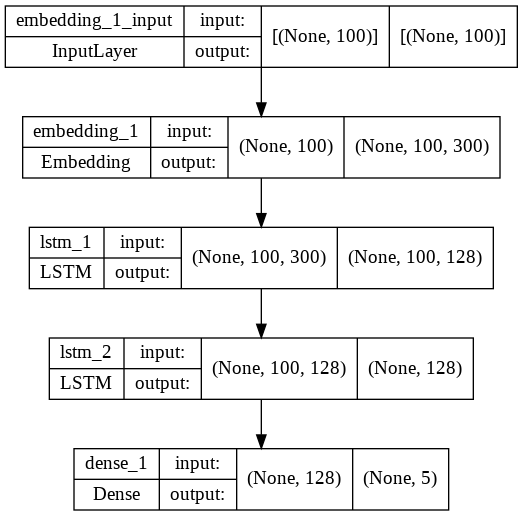

In [ ]:
keras.utils.plot_model(model_lstm_2, to_file="my_ref3_model.png", show_shapes=True)

##### Training and validation loss and accuracy

In [ ]:
history = model_lstm_2.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test,y_test))

Epoch 1/20
7/7 [==============================] - 4s 161ms/step - loss: 1.3085 - accuracy: 0.6923 - val_loss: 0.6699 - val_accuracy: 0.8549
Epoch 2/20
7/7 [==============================] - 0s 31ms/step - loss: 0.8953 - accuracy: 0.7635 - val_loss: 0.7144 - val_accuracy: 0.8549
Epoch 3/20
7/7 [==============================] - 0s 28ms/step - loss: 0.8327 - accuracy: 0.7635 - val_loss: 0.6004 - val_accuracy: 0.8549
Epoch 4/20
7/7 [==============================] - 0s 28ms/step - loss: 0.7147 - accuracy: 0.7876 - val_loss: 0.6071 - val_accuracy: 0.8549
Epoch 5/20
7/7 [==============================] - 0s 26ms/step - loss: 0.5695 - accuracy: 0.8037 - val_loss: 0.5835 - val_accuracy: 0.8549
Epoch 6/20
7/7 [==============================] - 0s 26ms/step - loss: 0.4156 - accuracy: 0.8370 - val_loss: 0.5159 - val_accuracy: 0.8549
Epoch 7/20
7/7 [==============================] - 0s 26ms/step - loss: 0.2969 - accuracy: 0.9013 - val_loss: 0.5555 - val_accuracy: 0.8549
Epoch 8/20
7/7 [==========

In [ ]:
val_loss, val_acc = model_lstm_2.evaluate(X_test, y_test)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

7/7 [==============================] - 0s 11ms/step - loss: 0.8808 - accuracy: 0.8549
Validation Loss: 0.8808131217956543
Validation Accuracy: 0.8549222946166992


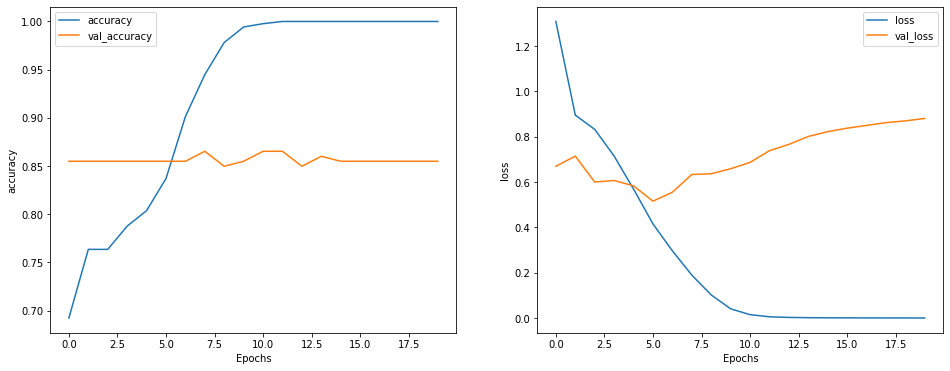

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
print(model_lstm_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          219648    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 6,351,877
Trainable params: 6,351,877
Non-trainable params: 0
_________________________________________________________________
None


##### Confusion matrix and classification report

In [ ]:
print("Categorical Mapping: ", integer_mapping)

Categorical Mapping:  {'PREVENT': 0, 'SIDE_EFF': 1, 'TREAT_FOR_DIS': 2, 'TREAT_NO_FOR_DIS': 3, 'VAGUE': 4}


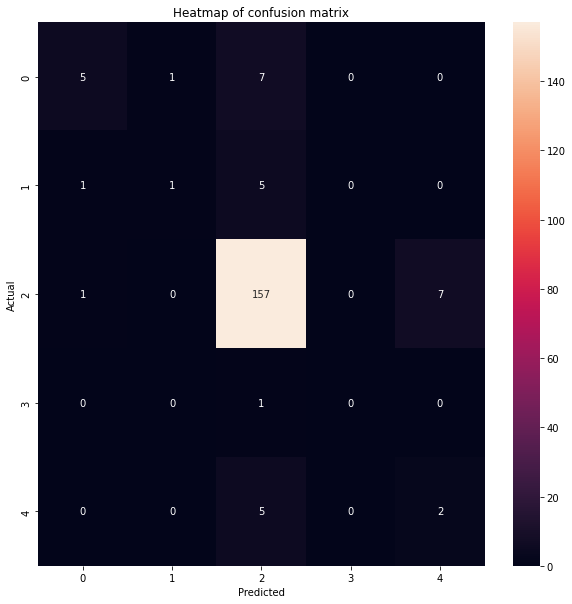

In [ ]:

prediction_probas = model_lstm_2.predict(X_test) 
predictions = np.argmax(prediction_probas, axis=1)

conf_matrix = confusion_matrix(rounded_y_test, predictions)

fig, ax = plt.subplots(figsize =(10,10))

sns.heatmap(conf_matrix, annot=True, fmt="d");

plt.title('Heatmap of confusion matrix') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 

plt.show()

In [ ]:
print(classification_report(rounded_y_test, predictions, digits=3, zero_division=0)) #Delete zero_division param to see warnings

              precision    recall  f1-score   support

           0      0.714     0.385     0.500        13
           1      0.500     0.143     0.222         7
           2      0.897     0.952     0.924       165
           3      0.000     0.000     0.000         1
           4      0.222     0.286     0.250         7

    accuracy                          0.855       193
   macro avg      0.467     0.353     0.379       193
weighted avg      0.841     0.855     0.840       193



##### Saving model

In [ ]:
# !mkdir -p lstm_2_saved_model    #/content/lstm_2_saved_model
# model_lstm_2.save('/content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_2_saved_model/lstm_2_model')

# # /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_2_saved_model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_2_saved_model/lstm_2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/lstm_2_saved_model/lstm_2_model/assets


#### 2 layer Bi-LSTM

##### Model setup

In [ ]:

embedding_size = 300
model_Bilstm_2 = keras.models.Sequential()
model_Bilstm_2.add(Embedding(n_most_common_words, embedding_size, input_length=X_train.shape[1]))
model_Bilstm_2.add(Bidirectional(LSTM(128,return_sequences=True)))
model_Bilstm_2.add(Bidirectional(LSTM(128)))
model_Bilstm_2.add(Dense(y_train.shape[1], activation='softmax'))
model_Bilstm_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_Bilstm_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 6,834,821
Trainable params: 6,834,821
Non-trainable params: 0
_________________________________________________________________
None


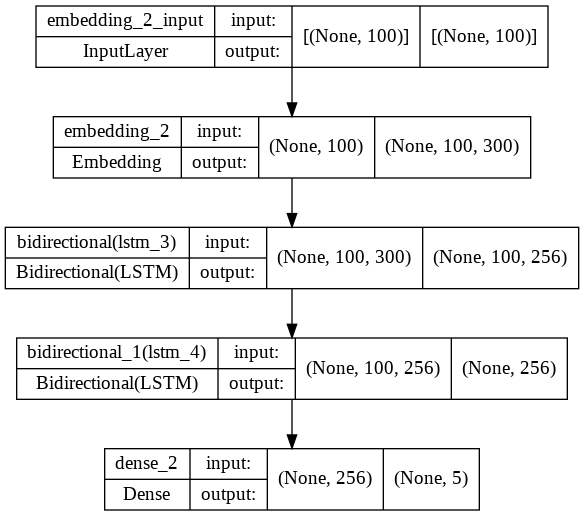

In [ ]:
keras.utils.plot_model(model_Bilstm_2, to_file="my_ref3_model.png", show_shapes=True)

##### Training and validation loss and accuracy

In [ ]:
history = model_Bilstm_2.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test,y_test))

Epoch 1/20
7/7 [==============================] - 7s 285ms/step - loss: 1.1622 - accuracy: 0.7382 - val_loss: 0.6309 - val_accuracy: 0.8549
Epoch 2/20
7/7 [==============================] - 0s 53ms/step - loss: 0.8584 - accuracy: 0.7635 - val_loss: 0.6724 - val_accuracy: 0.8549
Epoch 3/20
7/7 [==============================] - 0s 62ms/step - loss: 0.8018 - accuracy: 0.7635 - val_loss: 0.5978 - val_accuracy: 0.8549
Epoch 4/20
7/7 [==============================] - 0s 52ms/step - loss: 0.6342 - accuracy: 0.7807 - val_loss: 0.5938 - val_accuracy: 0.8549
Epoch 5/20
7/7 [==============================] - 0s 47ms/step - loss: 0.4133 - accuracy: 0.8462 - val_loss: 0.6184 - val_accuracy: 0.8446
Epoch 6/20
7/7 [==============================] - 0s 49ms/step - loss: 0.2745 - accuracy: 0.9185 - val_loss: 0.7573 - val_accuracy: 0.8446
Epoch 7/20
7/7 [==============================] - 0s 49ms/step - loss: 0.1460 - accuracy: 0.9633 - val_loss: 0.7569 - val_accuracy: 0.8290
Epoch 8/20
7/7 [==========

In [ ]:
val_loss, val_acc = model_Bilstm_2.evaluate(X_test, y_test)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

7/7 [==============================] - 0s 12ms/step - loss: 1.1602 - accuracy: 0.8290
Validation Loss: 1.1602280139923096
Validation Accuracy: 0.8290155529975891


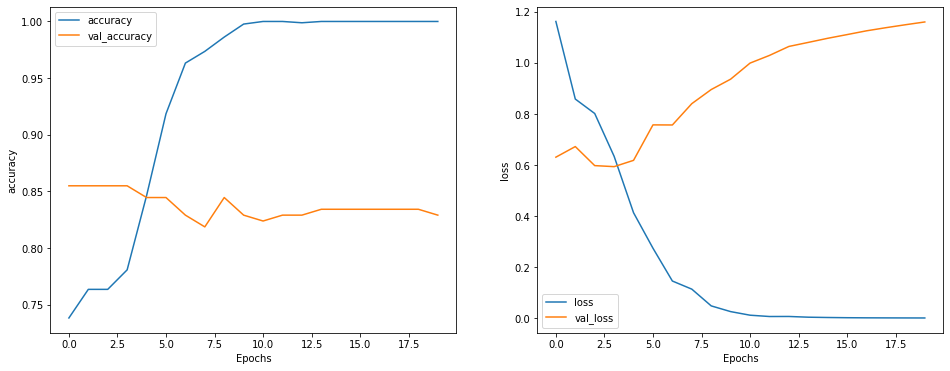

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
print(model_Bilstm_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 6,834,821
Trainable params: 6,834,821
Non-trainable params: 0
_________________________________________________________________
None


##### Confusion matrix and classification report

In [ ]:
print("Categorical Mapping: ", integer_mapping)

Categorical Mapping:  {'PREVENT': 0, 'SIDE_EFF': 1, 'TREAT_FOR_DIS': 2, 'TREAT_NO_FOR_DIS': 3, 'VAGUE': 4}


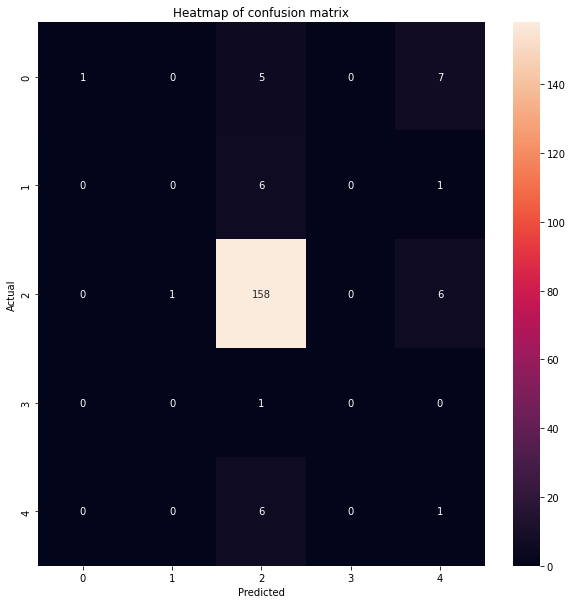

In [ ]:

prediction_probas = model_Bilstm_2.predict(X_test) 
predictions = np.argmax(prediction_probas, axis=1)

conf_matrix = confusion_matrix(rounded_y_test, predictions)

fig, ax = plt.subplots(figsize =(10,10))

sns.heatmap(conf_matrix, annot=True, fmt="d");

plt.title('Heatmap of confusion matrix') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 

plt.show()

In [ ]:
print(classification_report(rounded_y_test, predictions, digits=3, zero_division=0)) #Delete zero_division param to see warnings

              precision    recall  f1-score   support

           0      1.000     0.077     0.143        13
           1      0.000     0.000     0.000         7
           2      0.898     0.958     0.927       165
           3      0.000     0.000     0.000         1
           4      0.067     0.143     0.091         7

    accuracy                          0.829       193
   macro avg      0.393     0.235     0.232       193
weighted avg      0.837     0.829     0.805       193



##### Saving model

In [ ]:
# !mkdir -p Bilstm_2_saved_model    #/content/Bilstm_2_saved_model
# model_Bilstm_2.save('/content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/Bilstm_2_saved_model/Bilstm_2_model')

# # /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/Bilstm_2_saved_model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/Bilstm_2_saved_model/Bilstm_2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/Bilstm_2_saved_model/Bilstm_2_model/assets


### Transformer Models

#### Standard setup

In [ ]:
import transformers

print(transformers.__version__)

4.18.0


In [ ]:

from transformers import AutoTokenizer

from transformers import AutoModelForSequenceClassification, AutoModel, TrainingArguments, Trainer, TFAutoModelForSequenceClassification


In [ ]:

from datasets import Dataset

BioTrain_ds = Dataset.from_pandas(aug_BioTrain)
BioTest_ds = Dataset.from_pandas(BioTest)
y_test =BioTest_ds['Type_ENC']

In [ ]:
print(BioTrain_ds)
print(BioTest_ds)

Dataset({
    features: ['Sentence', 'Type', 'Treatment', 'Disease', 'Type_ENC'],
    num_rows: 871
})
Dataset({
    features: ['Sentence', 'Type', 'Treatment', 'Disease', 'Type_ENC'],
    num_rows: 193
})


#### Finetuning Bert

##### Model setup

In [ ]:
tokenizer_model_name = "bert-base-uncased"  

tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_name)

In [ ]:
tokenizer.is_fast

True

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["Sentence"], truncation=True)

In [ ]:
tokenized_BioTrain_ds = BioTrain_ds.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_BioTest_ds = BioTest_ds.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
print(tokenized_BioTrain_ds)

Dataset({
    features: ['Sentence', 'Type', 'Treatment', 'Disease', 'Type_ENC', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 871
})


In [ ]:
tf_train_dataset = tokenized_BioTrain_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["Type_ENC"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_BioTest_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["Type_ENC"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_BioTrain_ds) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_bert = TFAutoModelForSequenceClassification.from_pretrained(tokenizer_model_name, num_labels=5)  

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
print(model_bert.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# keras.utils.plot_model(model_bert, to_file="my_bert_model.png", show_shapes=True)

##### Training and validation loss and accuracy

In [ ]:
history = model_bert.fit(x=tf_train_dataset, validation_data=tf_validation_dataset, epochs=15)


Epoch 1/15
54/54 [==============================] - 35s 305ms/step - loss: 0.9347 - accuracy: 0.7407 - val_loss: 0.5922 - val_accuracy: 0.8549
Epoch 2/15
54/54 [==============================] - 14s 252ms/step - loss: 0.7321 - accuracy: 0.7720 - val_loss: 0.5225 - val_accuracy: 0.8549
Epoch 3/15
54/54 [==============================] - 14s 253ms/step - loss: 0.5780 - accuracy: 0.8090 - val_loss: 0.4704 - val_accuracy: 0.8549
Epoch 4/15
54/54 [==============================] - 14s 256ms/step - loss: 0.4753 - accuracy: 0.8310 - val_loss: 0.4564 - val_accuracy: 0.8705
Epoch 5/15
54/54 [==============================] - 14s 257ms/step - loss: 0.4217 - accuracy: 0.8542 - val_loss: 0.4390 - val_accuracy: 0.8756
Epoch 6/15
54/54 [==============================] - 14s 263ms/step - loss: 0.4064 - accuracy: 0.8646 - val_loss: 0.4390 - val_accuracy: 0.8756
Epoch 7/15
54/54 [==============================] - 14s 259ms/step - loss: 0.4120 - accuracy: 0.8623 - val_loss: 0.4390 - val_accuracy: 0.8756

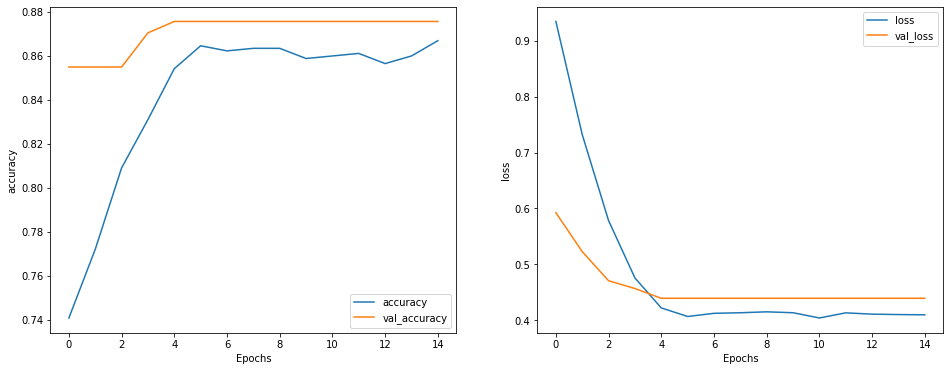

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
print(model_bert.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________
None


##### Confusion matrix and classification report

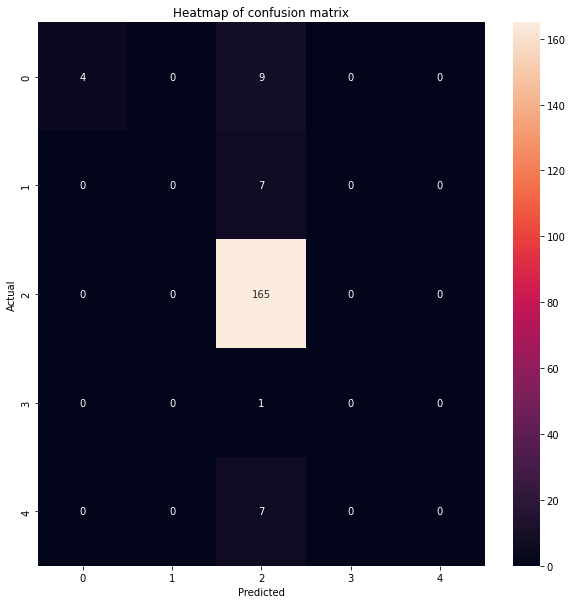

In [ ]:
preds = model_bert.predict(tf_validation_dataset)
pred_labels = np.argmax(preds.logits, axis=1)

conf_matrix = confusion_matrix(y_test,pred_labels)


fig, ax = plt.subplots(figsize =(10,10))

sns.heatmap(conf_matrix, annot=True, fmt="d");

plt.title('Heatmap of confusion matrix') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 

plt.show()

In [ ]:
print(classification_report(y_test, pred_labels, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      1.000     0.308     0.471        13
           1      0.000     0.000     0.000         7
           2      0.873     1.000     0.932       165
           3      0.000     0.000     0.000         1
           4      0.000     0.000     0.000         7

    accuracy                          0.876       193
   macro avg      0.375     0.262     0.281       193
weighted avg      0.814     0.876     0.829       193



##### Saving model

In [ ]:
# !mkdir -p bert_saved_model    #/content/bert_saved_model
# model_bert.save('/content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/bert_saved_model/bert_model')

# # /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/bert_saved_model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/bert_saved_model/bert_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/bert_saved_model/bert_model/assets


#### Finetuning BioBert

##### Model setup

In [ ]:
tokenizer_model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_name, from_pt=True)

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

In [ ]:
tokenizer.is_fast

True

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["Sentence"], truncation=True)

In [ ]:
tokenized_BioTrain_ds = BioTrain_ds.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
tokenized_BioTest_ds = BioTest_ds.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
print(tokenized_BioTrain_ds)

Dataset({
    features: ['Sentence', 'Type', 'Treatment', 'Disease', 'Type_ENC', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 871
})


In [ ]:
tf_train_dataset = tokenized_BioTrain_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["Type_ENC"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_BioTest_ds.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["Type_ENC"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_BioTrain_ds) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_biobert = TFAutoModelForSequenceClassification.from_pretrained(tokenizer_model_name, num_labels=5, from_pt=True)  

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_biobert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
print(model_biobert.summary())

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# keras.utils.plot_model(model_biobert, to_file="my_biobert_model.png", show_shapes=True)

##### Training and validation loss and accuracy

In [ ]:
history = model_biobert.fit(x=tf_train_dataset, validation_data=tf_validation_dataset, epochs=15)


Epoch 1/15
54/54 [==============================] - 34s 329ms/step - loss: 1.0020 - accuracy: 0.6736 - val_loss: 0.5178 - val_accuracy: 0.8549
Epoch 2/15
54/54 [==============================] - 15s 271ms/step - loss: 0.5586 - accuracy: 0.7986 - val_loss: 0.3556 - val_accuracy: 0.8860
Epoch 3/15
54/54 [==============================] - 15s 272ms/step - loss: 0.3161 - accuracy: 0.9236 - val_loss: 0.3111 - val_accuracy: 0.8860
Epoch 4/15
54/54 [==============================] - 15s 272ms/step - loss: 0.2054 - accuracy: 0.9757 - val_loss: 0.2824 - val_accuracy: 0.9016
Epoch 5/15
54/54 [==============================] - 15s 275ms/step - loss: 0.1592 - accuracy: 0.9850 - val_loss: 0.2859 - val_accuracy: 0.8964
Epoch 6/15
54/54 [==============================] - 15s 274ms/step - loss: 0.1480 - accuracy: 0.9896 - val_loss: 0.2859 - val_accuracy: 0.8964
Epoch 7/15
54/54 [==============================] - 15s 268ms/step - loss: 0.1465 - accuracy: 0.9873 - val_loss: 0.2859 - val_accuracy: 0.8964

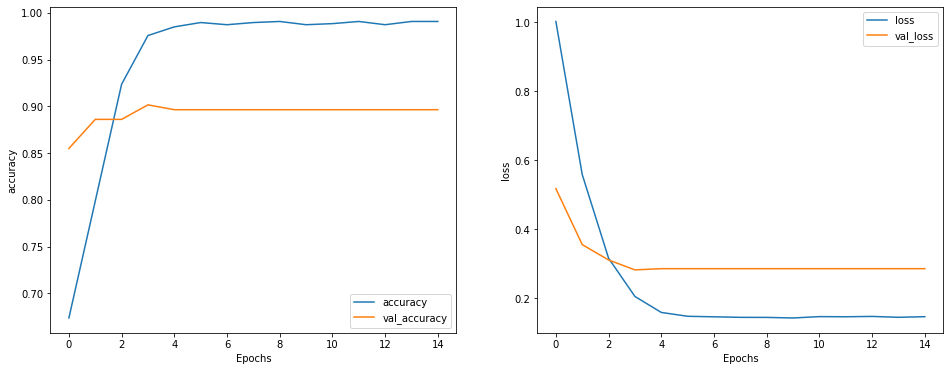

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
print(model_biobert.summary())

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________
None


##### Confusion matrix and classification report

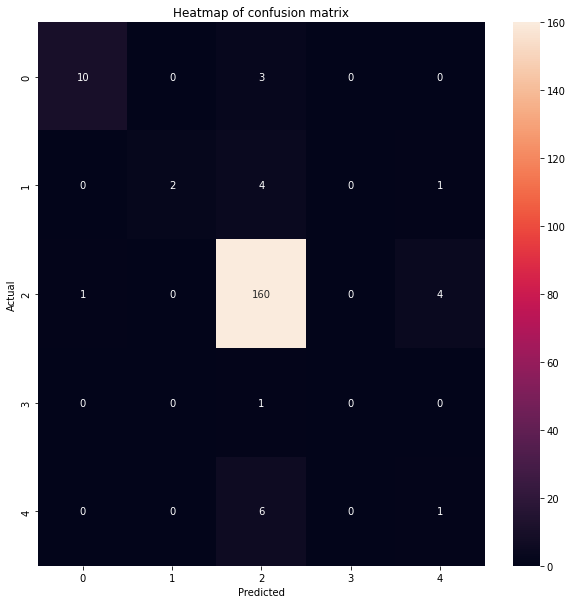

In [ ]:
preds = model_biobert.predict(tf_validation_dataset)
pred_labels = np.argmax(preds.logits, axis=1)

conf_matrix = confusion_matrix(y_test,pred_labels)


fig, ax = plt.subplots(figsize =(10,10))

sns.heatmap(conf_matrix, annot=True, fmt="d");

plt.title('Heatmap of confusion matrix') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 

plt.show()

In [ ]:
print(classification_report(y_test, pred_labels, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      0.909     0.769     0.833        13
           1      1.000     0.286     0.444         7
           2      0.920     0.970     0.944       165
           3      0.000     0.000     0.000         1
           4      0.167     0.143     0.154         7

    accuracy                          0.896       193
   macro avg      0.599     0.433     0.475       193
weighted avg      0.890     0.896     0.885       193



##### Saving model

In [ ]:
# !mkdir -p biobert_saved_model    #/content/biobert_saved_model
# model_biobert.save('/content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/biobert_saved_model/biobert_model')

# # /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/biobert_saved_model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/biobert_saved_model/biobert_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Final Project Work/Saved models/biobert_saved_model/biobert_model/assets


## Summary and conclusions:

The RE task of distinguishing disease-treatment relations is successfully performed on
biomedical texts. This is a difficult, and crucial task in NLP, specifically in the effort to
automate medical decision support.
LSTM models, fine-tuned BERT and fine-tuned BioBERT models are developed and
evaluated for classification accuracy and F1-score on the BioText dataset. 
The best performing model was the fine-tuned BioBERT model, which was expected, as it is
pretrained on Biomedical specific corpuses.

Future work can extend the work by increasing the sample size for each relation with
additional relevant datasets. The original dataset was annotated by experts, but this task could
also be automated using ML methods such as Named Entity Recognition (NER), in order to
significantly increase dataset size. Dataset size, and specifically the long-tailed distribution of
27
samples per relational class was a significant factor in the poor performance of classification
and F1-scores for the relations other than the ‘TREAT_FOR DIS’ class. Additional relation
types outside of the five relations considered relevant and evaluated here could also be
assessed. Consequently, implementation of well performing models incorporated into
healthcare systems could be beneficial for efficient medical decision support. 

## References:



1.   B. University of California, "The BioText Project," [Online]. Available:
https://biotext.berkeley.edu/dis_treat_data.html. [Accessed 15 04 2022].
2.   B. Rosario and M. Hearst, "Classifying Semantic Relations in Bioscience Texts," ACL, 2004. 

